In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
import string
import re
import torch.nn.functional as F
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import  os
from sklearn.preprocessing import LabelEncoder


ModuleNotFoundError: No module named 'torch'

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda == True:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Our Device =====>>>>>>", device)
df = pd.read_csv( '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

(40000,)
(10000,)


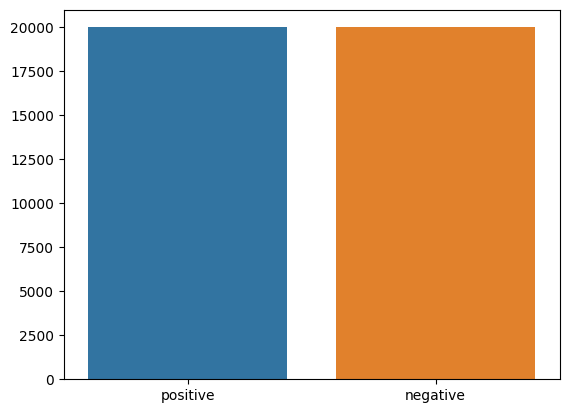

In [76]:
X = df['review'].values # Converts it into numpy array
y = df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y) #stratify = y ===>positive and negative ratio of train and test data will be equal
print(x_train.shape)
print(x_test.shape)
totalcount = pd.Series(y_train).value_counts()
totalcount
sns.barplot(x = np.array(['positive', 'negative']), y= totalcount.values)
plt.show()

In [1]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
  
    stop_words = set(stopwords.words('english'))
    for sentence in x_train:
        for word in sentence.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus_counter = Counter(word_list)
    corpus = sorted(corpus_counter, key=corpus_counter.get, reverse = True)[:1000]
    one_hot_vec_dic = {}
    for i, corp in enumerate(corpus_counter):
        one_hot_vec_dic[corp] = i + 1
    final_x_train = []
    final_x_val = []
    
    for sentence in x_train:
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                final_x_train.append(one_hot_vec_dic[ppword])

    for sentence in x_val:
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                final_x_val.append(one_hot_vec_dic[ppword])  
    le = LabelEncoder()
    encode_train = le.fit_transform(y_train)
    encode_val = le.fit_transform(y_val)
    return np.array(final_x_train),np.array(final_x_val), encode_train, encode_val, one_hot_vec_dic
    

            
        
st = ['World is beautiful. USA is the best. I will go to USA only.']

labels = ['positive', 'negative', 'positive', 'negative', 'positive']

tockenize(st,labels,st,labels)        


NameError: name 'stopwords' is not defined

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, output_dim, hidden_dim, embedding_dim,drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim )
        self.rnn = nn.RNN(input_size = embedding_dim, hidden_size = self.hidden_dim, num_layers = no_layers, batch_first = True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        self.sig = nn.Sigmoid()
       



# batch_size = 5
# seq_length = 10
# hidden_dim = 20
# num_layers = 1

# rnn_out, hidden = self.rnn(embedding_layer, hidden)
# Then:

# rnn_out.shape → (5, 10, 20) (all hidden states for all words)
# hidden.shape → (1, 5, 20) (final hidden state for each sequence)
# rnn_out[:, -1, :] → (5, 20) (last word's output)
# hidden.squeeze(0) → (5, 20) (last hidden state)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeding_layer = self.embedding(x)
        rnn_out, hidden = self.rnn(embeding_layer, hidden)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim) 
        out = self.dropout(rnn_out)
        out = self.fc(out)
        sig_out = self.sig(out)  
        batch_size = x.size(0)
        sig_out = sig_out.view(batch_size, -1) 
        sig_out = sig_out[:, -1] 
        return sig_out, hidden


    def init_hidden(self, batch_size):
        #intializing first hidden state
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        return (h0,c0)
        
        